<a href="https://colab.research.google.com/github/untrall/cs8803asi/blob/main/Object_Detection_Fine_Tune_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Fine Tune Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1t8pM9U7-QZkip8b3UxTCYPBfkFq0JP5w#scrollTo=9f2c663c"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [ ]:
!pip install evadb

In [ ]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

### Download the Videos and Required Scripts

In [ ]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1 -O ua_detrac.mp4
# Getting the fine-tuned Yolo object detector
!wget -nc https://raw.githubusercontent.com/untrall/cs8803asi/main/yolo_fine_tune.py
# Getting the fine-tuned Yolo object detector
!wget -nc https://raw.githubusercontent.com/untrall/cs8803asi/main/yolo_with_filter.py
# Getting the fine-tuned weights for YoloV5
!wget -nc https://raw.githubusercontent.com/untrall/cs8803asi/main/model.pt

File ‘ua_detrac.mp4’ already there; not retrieving.
File ‘yolo_fine_tune.py’ already there; not retrieving.

File ‘yolo_with_filter.py’ already there; not retrieving.

File ‘model.pt’ already there; not retrieving.



### Load the surveillance videos for analysis

##### We use regular expression to load all the videos into the table

In [ ]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Table: ObjectDetectionVideos does not exist
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.21290021000004344


### Visualize Video

In [ ]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Register YOLO Object Detector with fine-tuned weights as a User-Defined Function (UDF) in EVA 

In [ ]:
## custom fine-tuned weights are already loaded in yolo_fine_tune.py
cursor.execute("""CREATE UDF IF NOT EXISTS YoloV5_Fine_Tune
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'yolo_fine_tune.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                           0
0  UDF YoloV5_Fine_Tune successfully added to the database.
@query_time: 3.358700063000015


### Run Object Detector with fine-tuned weights on the video

In [ ]:
cursor.execute("""SELECT id, YoloV5_Fine_Tune(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response_1 = cursor.fetch_all()
response_1.as_df().head(10)

objectdetectionvideos.id  \
0                         0   
1                         1   
2                         2   
3                         3   
4                         4   
5                         5   
6                         6   
7                         7   
8                         8   
9                         9   

                             yolov5_fine_tune.labels  \
0  [car, car, car, car, car, car, car, car, car, ...   
1  [car, car, car, car, car, car, car, car, car, ...   
2  [car, car, car, car, car, car, car, car, car, ...   
3  [car, car, car, car, car, car, car, car, car, ...   
4  [car, car, car, car, car, car, car, car, car, ...   
5  [car, car, car, car, car, car, car, car, car, ...   
6  [car, car, car, car, car, car, car, car, car, ...   
7  [car, car, car, car, car, car, car, car, car, ...   
8  [car, car, car, car, car, car, car, car, car, ...   
9  [car, car, car, car, car, car, car, car, car, ...   

                             yolov5_fine_tune.bboxes  \
0  0     [344.8067932128906, 161.20376586914062, ...   
1  0     [344.0391845703125, 159.93601989746094, ...   
2  0     [343.340087890625, 158.7260284423828, 38...   
3  0     [225.69769287109375, 276.7891540527344, ...   
4  0     [226.0989990234375, 275.2127685546875, 3...   
5  0     [227.2132110595703, 272.5289001464844, 3...   
6  0     [855.5936279296875, 283.8282165527344, 9...   
7  0     [229.84661865234375, 272.3326416015625, ...   
8  0     [229.79049682617188, 270.1840515136719, ...   
9  0     [229.74533081054688, 268.3025817871094, ...   

                             yolov5_fine_tune.scores  
0  [0.9163848161697388, 0.9108870625495911, 0.901...  
1  [0.9181259274482727, 0.9156779050827026, 0.900...  
2  [0.9107299447059631, 0.9058220386505127, 0.901...  
3  [0.9258052706718445, 0.9152998924255371, 0.904...  
4  [0.9318802356719971, 0.9098677039146423, 0.908...  
5  [0.9353177547454834, 0.9241135716438293, 0.907...  
6  [0.9086148142814636, 0.9067200422286987, 0.896...  
7  [0.9061141014099121, 0.8994451761245728, 0.891...  
8  [0.9048574566841125, 0.8945248126983643, 0.891...  
9  [0.9193609952926636, 0.8978973627090454, 0.892...

### Visualizing output of the Object Detector on the video

In [ ]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolov5_fine_tune.bboxes', 'yolov5_fine_tune.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

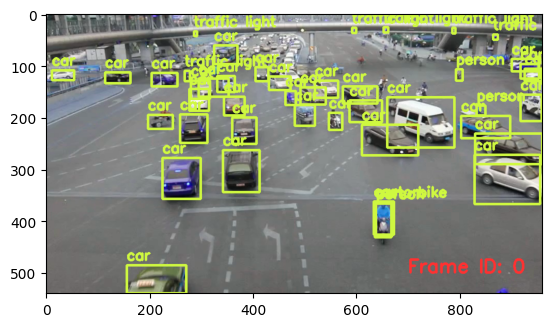

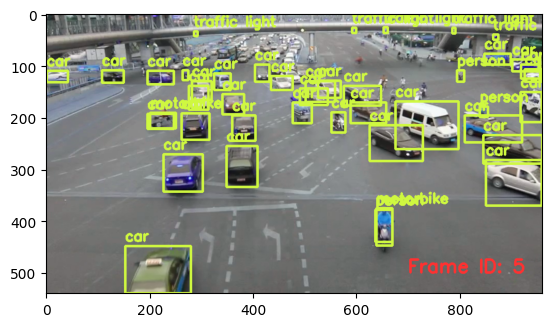

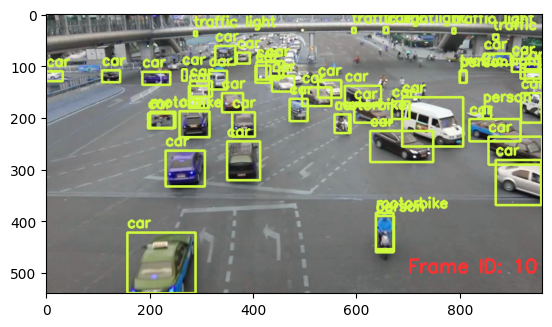

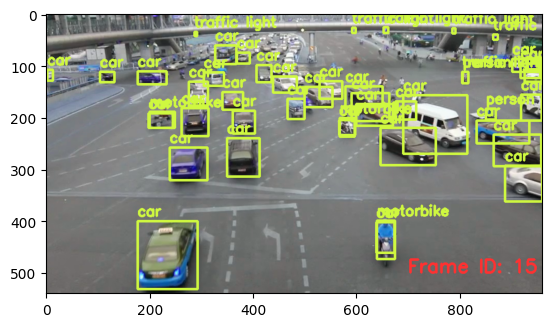

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\r\xfd\xbemdat\x00\x…

In [ ]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response_1.as_df()
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping YOLOv5 User-Defined Function (UDF)

In [ ]:
cursor.execute("DROP UDF YoloV5;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                  0
0  UDF YoloV5 successfully dropped
@query_time: 0.059638441999993574


### Register YOLO Object Detector with label filtering as a User-Defined Function (UDF) in EVA 

In [ ]:
## custom fine-tuned weights are already loaded in yolo_fine_tune.py
cursor.execute("""CREATE UDF IF NOT EXISTS YoloV5_Filter
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'yolo_with_filter.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                        0
0  UDF YoloV5_Filter successfully added to the database.
@query_time: 1.031372540999996


### Run Object Detector with filter on the video

#####In the line:48 of the yolo_with_filter.py, modify the self.filter list to list of labels you want to filter out

In [ ]:
cursor.execute("""SELECT id, YoloV5_Filter(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response_1 = cursor.fetch_all()
response_1.as_df().head(10)

objectdetectionvideos.id  \
0                         0   
1                         1   
2                         2   
3                         3   
4                         4   
5                         5   
6                         6   
7                         7   
8                         8   
9                         9   

                                yolov5_filter.labels  \
0  [traffic light, traffic light, traffic light, ...   
1  [traffic light, traffic light, traffic light, ...   
2  [traffic light, traffic light, traffic light, ...   
3  [traffic light, traffic light, traffic light, ...   
4  [traffic light, traffic light, traffic light, ...   
5  [traffic light, traffic light, traffic light, ...   
6  [traffic light, traffic light, traffic light, ...   
7  [traffic light, traffic light, traffic light, ...   
8  [traffic light, traffic light, traffic light, ...   
9  [traffic light, traffic light, traffic light, ...   

                                yolov5_filter.bboxes  \
0  [[865.2734985351562, 41.525028228759766, 874.8...   
1  [[865.3033447265625, 41.5169563293457, 874.830...   
2  [[865.2709350585938, 41.4979362487793, 874.784...   
3  [[865.2822875976562, 41.5355110168457, 874.846...   
4  [[865.3717041015625, 41.53645706176758, 874.83...   
5  [[865.6419067382812, 41.399871826171875, 875.0...   
6  [[865.636962890625, 41.378726959228516, 875.03...   
7  [[865.6985473632812, 41.32562255859375, 875.15...   
8  [[865.6248779296875, 41.35513687133789, 875.14...   
9  [[865.5650634765625, 41.310951232910156, 875.1...   

                                yolov5_filter.scores  
0  [0.6249580979347229, 0.5684185028076172, 0.500...  
1  [0.6272468566894531, 0.5682201385498047, 0.490...  
2  [0.6292749643325806, 0.567243754863739, 0.4919...  
3  [0.6275845766067505, 0.5599822402000427, 0.491...  
4  [0.6255011558532715, 0.5807507634162903, 0.493...  
5  [0.6323979496955872, 0.5839106440544128, 0.494...  
6  [0.6257152557373047, 0.5504021048545837, 0.465...  
7  [0.6200948357582092, 0.5308473110198975, 0.485...  
8  [0.6187275648117065, 0.5298051834106445, 0.508...  
9  [0.619587779045105, 0.5269742608070374, 0.5107...

### Visualizing output of the Object Detector after filtering on the video

In [ ]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolov5_filter.bboxes', 'yolov5_filter.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

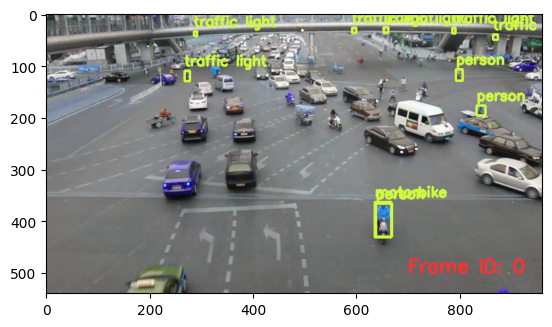

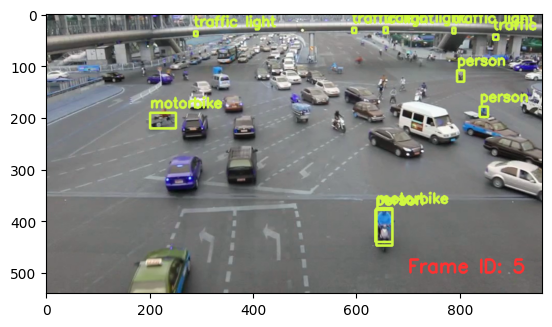

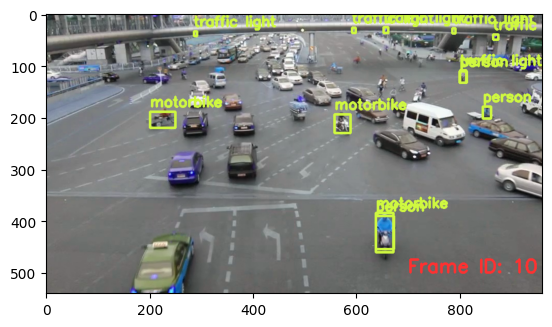

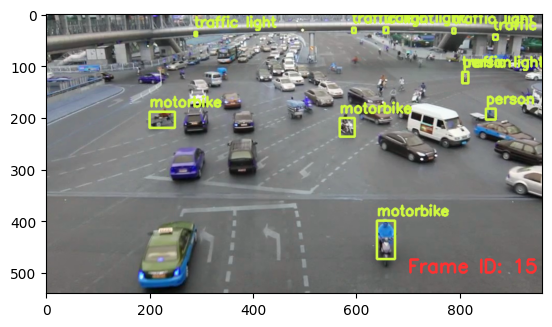

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x06\xe6\xcemdat\x00…

In [ ]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response_1.as_df()
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping YOLOv5 with filtering User-Defined Function (UDF)

In [ ]:
cursor.execute("DROP UDF YoloV5_Filter;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                         0
0  UDF YoloV5_Filter successfully dropped
@query_time: 0.04289639099999931
